# Лабораторна робота №3 - Multiview Training. Co-training. Democratic co-traning.

1. Імпорт залежностей

In [1]:
import random

import numpy as np
import torch

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision.transforms import v2
from torchvision.datasets import OxfordIIITPet

from lib.util.torch_device import resolve_torch_device
from lib.util.dataset import (
    SemiSupervisedDataset,
    WarmCachedDataset,
)
from src.definitions import EXTERNAL_DATA_FOLDER, MODELS_FOLDER
from src.data.util.dataset import get_mean_std
from src.visualization.image import sample_image_dataset
from src.visualization.plot import (
    plot_loss_and_val_accuracy,
    plot_loss_and_val_loss,
    plot_confusion_matrix_heatmap,
)
from src.model.lab_2 import Lab2Student
from src.model.lab_3 import CoTraining

2. Встановити сід генератору псевдовипадкових чисел

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

seeded_generator = torch.Generator().manual_seed(random_seed)
device = resolve_torch_device()

3. Завантажити обраний набір даних

In [3]:
original_trans = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
    ]
)

original_train_ds = OxfordIIITPet(
    EXTERNAL_DATA_FOLDER, download=True, transform=original_trans
)

class_names = original_train_ds.classes
num_classes = len(class_names)

original_train_loader = DataLoader(original_train_ds, batch_size=32)

mean, std = get_mean_std(original_train_loader)

print("Dataset mean: " + str(mean.tolist()))
print("Dataset std: " + str(std.tolist()))

Dataset mean: [0.4782784581184387, 0.44585439562797546, 0.39568495750427246]
Dataset std: [0.26004523038864136, 0.25474968552589417, 0.2626919746398926]


In [4]:
trans = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
        v2.Normalize(mean, std),
    ]
)

complete_train_ds = WarmCachedDataset(
    OxfordIIITPet(EXTERNAL_DATA_FOLDER, download=True, transform=trans)
)
test_ds = WarmCachedDataset(
    OxfordIIITPet(EXTERNAL_DATA_FOLDER, split="test", transform=trans)
)

4. Відобразити декілька зображень з набору даних у блокноті

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6733289..2.222426].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7255523..2.300471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8189831..1.3232499].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8275576..2.300471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.773299..2.2605126].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8392125..2.0062733].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7967324..2

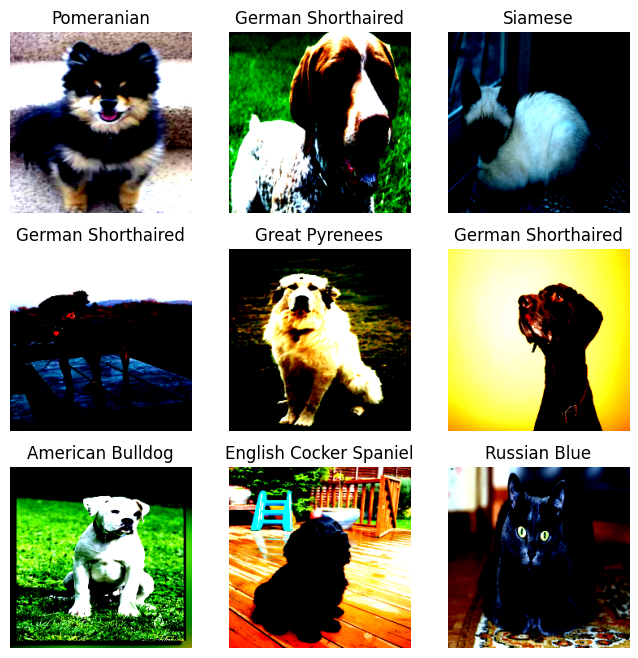

In [5]:
sample_image_dataset(complete_train_ds, labels=class_names)

5. Розділити обраний набір даних на дві вибірки: тренувальну та валідаційну, співвідношення розміру вибірок обрати на власний розсуд. Після чого розділити тренувальний набір на дві частини марковану(30%) та немарковану(70%);

In [6]:
batch_size = 256

train_ds, valid_ds = random_split(complete_train_ds, [0.931, 0.069], seeded_generator)
labeled_ds, unlabeled_ds = random_split(train_ds, [0.3, 0.7], seeded_generator)

train_loader = DataLoader(train_ds, batch_size=batch_size)
labeled_loader = DataLoader(labeled_ds, batch_size=batch_size)
valid_loader = DataLoader(valid_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

print("Train dataset size: " + str(len(train_ds)))
print("Labeled dataset size: " + str(len(labeled_ds)))
print("Unlabeled dataset size: " + str(len(unlabeled_ds)))
print("Validation dataset size: " + str(len(valid_ds)))
print("Test dataset size: " + str(len(test_ds)))

Train dataset size: 3427
Labeled dataset size: 1029
Unlabeled dataset size: 2398
Validation dataset size: 253
Test dataset size: 3669


6. Завантажити та налаштувати нейронну мережу обраної архітектури;

In [7]:
supervised = Lab2Student(device=device, num_classes=num_classes)

loss_fun = CrossEntropyLoss()
optimizer = Adam(supervised.parameters())

7. Провести навчання нейронної мережі на початковому (до розділу на маркований і немаркований) тренувальному наборі даних. Вибір гіперпараметрів на власний розсуд. Побудувати графіки точності та loss мережі під час навчання;


In [8]:
feedback = supervised.fit(
    num_epochs=10,
    train_loader=train_loader,
    valid_loader=valid_loader,
    loss_fun=loss_fun,
    optimizer=optimizer,
)

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy of the network: 83.77542892156863 %
Loss of the network: 0.7513848592837652


Lab2Student(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

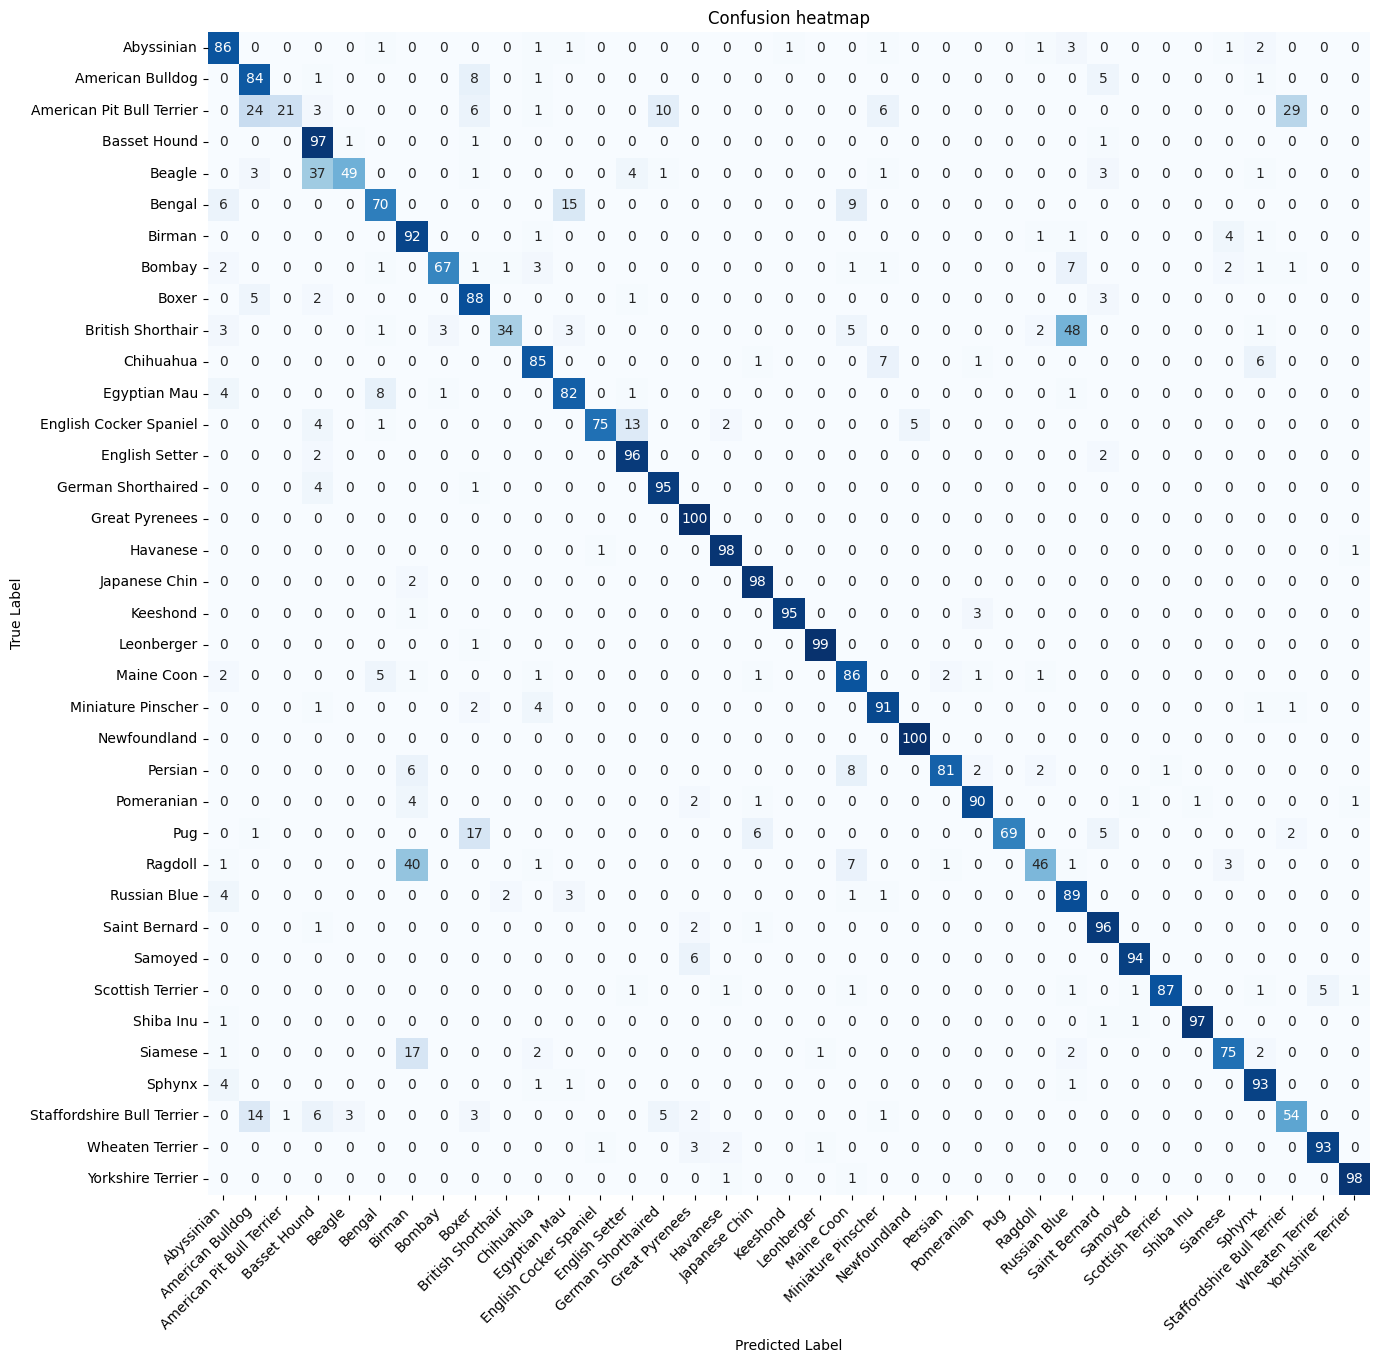

In [9]:
supervised.eval()

test_loss, test_accuracy, confusion = supervised.test(
    loss_fun, test_loader, record_class_stats=True
)

print("Accuracy of the network: %s %%" % (test_accuracy * 100))
print("Loss of the network: %s" % test_loss)

plot_confusion_matrix_heatmap(confusion, labels=class_names)

supervised.train()

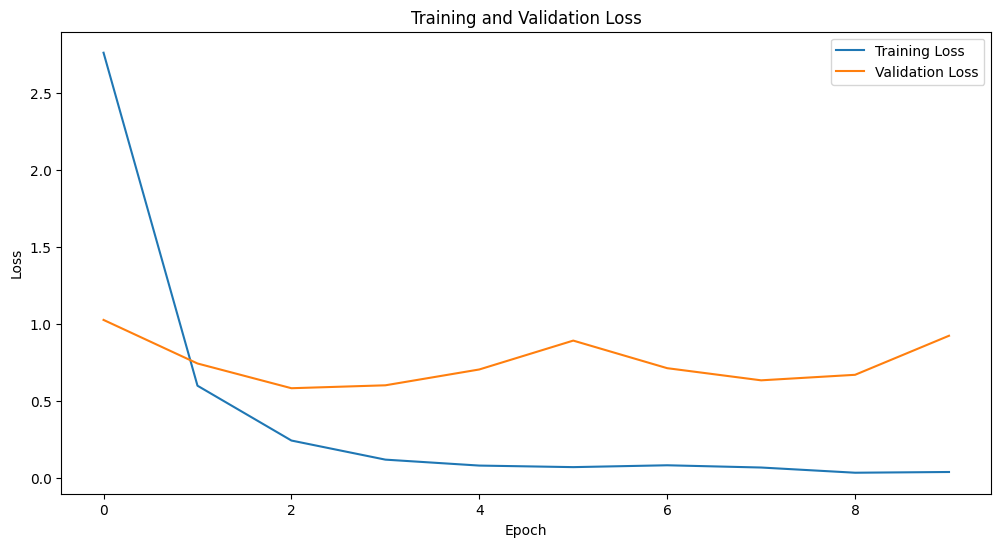

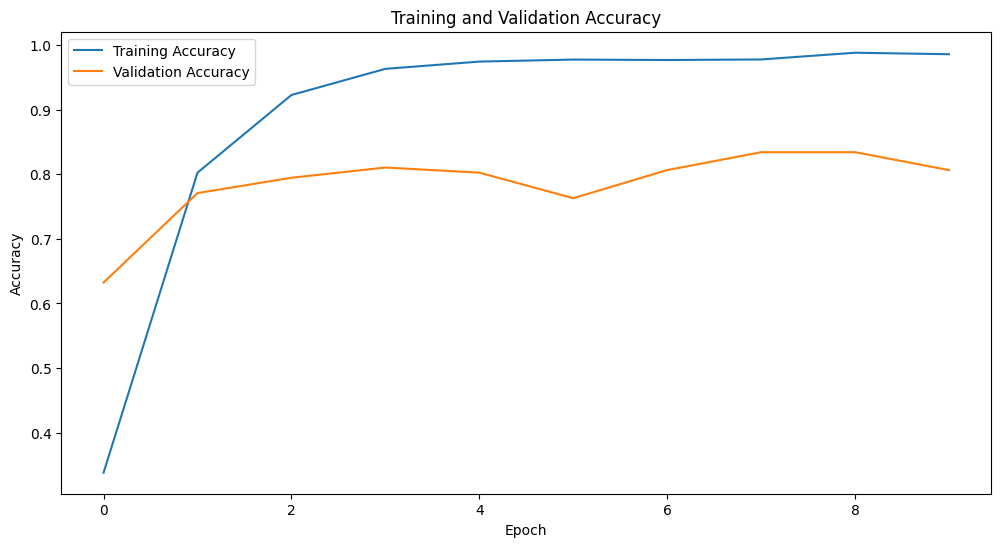

In [10]:
plot_loss_and_val_loss(feedback.train_loss_history, feedback.valid_loss_history)
plot_loss_and_val_accuracy(
    feedback.train_accuracy_history, feedback.valid_accuracy_history
)

8. Зберегти ваги навченої нейронної мережі у файл.

In [11]:
supervised.persist(MODELS_FOLDER / "lab-3-supervised.pickle")

9. Провести навчання нейронної мережі напівкерованим алгоритмом використовуючи маркований і немаркований набір даних на 4 кроці. Вибір гіперпараметрів на власний розсуд. Побудувати графік точності моделі;


In [12]:
model_1 = Lab2Student(device=device, num_classes=num_classes)
loss_fun_1 = CrossEntropyLoss()
optimizer_1 = Adam(model_1.parameters())

model_2 = Lab2Student(device=device, num_classes=num_classes)
loss_fun_2 = CrossEntropyLoss()
optimizer_2 = Adam(model_2.parameters())

In [13]:
train_ds_1, train_ds_2 = random_split(labeled_ds, [0.5, 0.5], seeded_generator)

train_loader_1 = DataLoader(train_ds_1, batch_size=batch_size)
train_loader_2 = DataLoader(train_ds_2, batch_size=batch_size)

In [14]:
feedback = model_1.fit(
    num_epochs=10,
    train_loader=train_loader_1,
    valid_loader=valid_loader,
    loss_fun=loss_fun_1,
    optimizer=optimizer_1,
)

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
model_1.eval()

test_loss, test_accuracy, _ = model_1.test(loss_fun_1, test_loader)

print("Accuracy of the network: %s %%" % (test_accuracy * 100))
print("Loss of the network: %s" % test_loss)

model_1.train()

Accuracy of the network: 62.359068627450974 %
Loss of the network: 1.5156750758488973


Lab2Student(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [16]:
feedback = model_2.fit(
    num_epochs=10,
    train_loader=train_loader_2,
    valid_loader=valid_loader,
    loss_fun=loss_fun_2,
    optimizer=optimizer_2,
)

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
model_2.eval()

test_loss, test_accuracy, _ = model_2.test(loss_fun_2, test_loader)

print("Accuracy of the network: %s %%" % (test_accuracy * 100))
print("Loss of the network: %s" % test_loss)

model_2.train()

Accuracy of the network: 62.202512254901954 %
Loss of the network: 1.5938197096188864


Lab2Student(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [18]:
unlabeled_ds_1, unlabeled_ds_2 = random_split(unlabeled_ds, [0.5, 0.5], seeded_generator)

unlabeled_loader_1 = DataLoader(unlabeled_ds_1, batch_size=batch_size)
unlabeled_loader_2 = DataLoader(unlabeled_ds_2, batch_size=batch_size)

model_1_labels_ds = SemiSupervisedDataset(
    unlabeled_ds_1, model_1.forward_loader(unlabeled_loader_1)
)
model_1_ds = ConcatDataset([labeled_ds, model_1_labels_ds])

model_2_labels_ds = SemiSupervisedDataset(
    unlabeled_ds_2, model_2.forward_loader(unlabeled_loader_2)
)
model_2_ds = ConcatDataset([labeled_ds, model_2_labels_ds])

model_all_ds = ConcatDataset([labeled_ds, model_1_labels_ds, model_2_labels_ds])

model_1_loader = DataLoader(model_1_ds, batch_size=batch_size)
model_2_loader = DataLoader(model_2_ds, batch_size=batch_size)
model_all_loader = DataLoader(model_all_ds, batch_size=batch_size)

print("Unlabeled 1 dataset size: " + str(len(unlabeled_ds_1)))
print("Unlabeled 2 dataset size: " + str(len(unlabeled_ds_2)))
print("Model 1 dataset size: " + str(len(model_1_ds)))
print("Model 2 dataset size: " + str(len(model_2_ds)))
print("Aggregated dataset size: " + str(len(model_all_ds)))

Unlabeled 1 dataset size: 1199
Unlabeled 2 dataset size: 1199
Model 1 dataset size: 2228
Model 2 dataset size: 2228
Aggregated dataset size: 3427


In [19]:
feedback = model_1.fit(
    num_epochs=10,
    train_loader=model_2_loader,
    valid_loader=valid_loader,
    loss_fun=loss_fun_1,
    optimizer=optimizer_1,
)

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

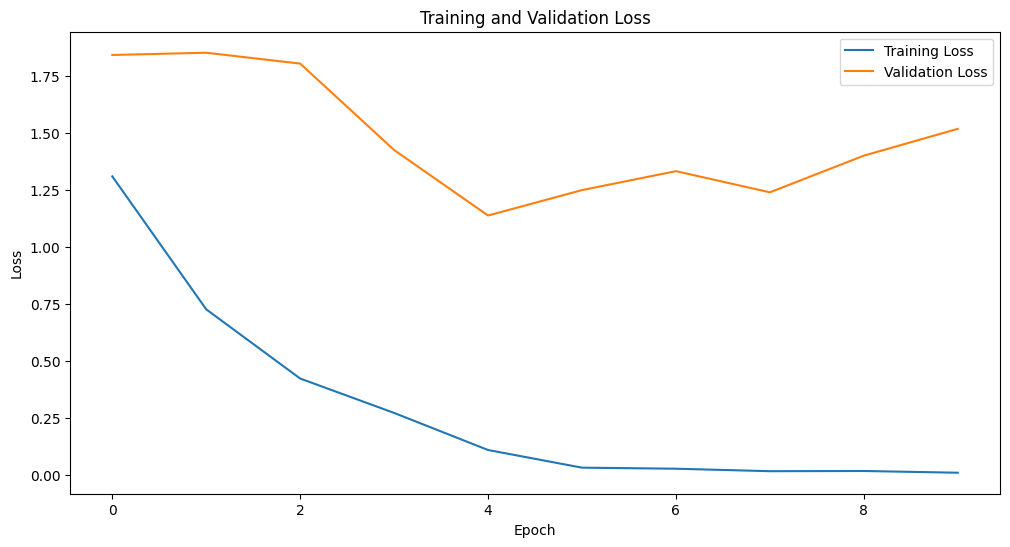

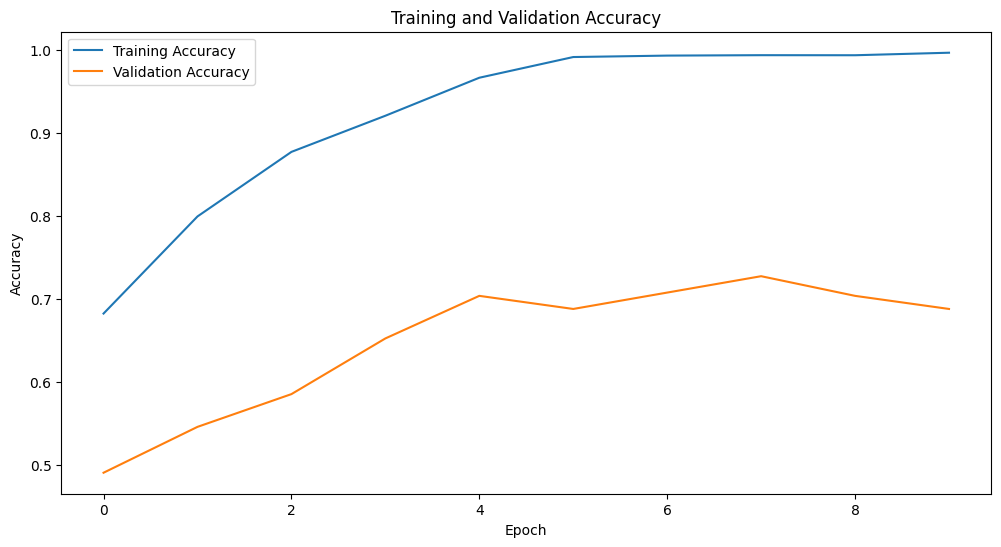

In [20]:
plot_loss_and_val_loss(feedback.train_loss_history, feedback.valid_loss_history)
plot_loss_and_val_accuracy(
    feedback.train_accuracy_history, feedback.valid_accuracy_history
)

In [21]:
model_1.eval()

test_loss, test_accuracy, _ = model_1.test(loss_fun_1, test_loader)

print("Accuracy of the network: %s %%" % (test_accuracy * 100))
print("Loss of the network: %s" % test_loss)

model_1.train()

Accuracy of the network: 70.82904411764707 %
Loss of the network: 1.3412038922309875


Lab2Student(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [22]:
feedback = model_2.fit(
    num_epochs=10,
    train_loader=model_1_loader,
    valid_loader=valid_loader,
    loss_fun=loss_fun_2,
    optimizer=optimizer_2,
)

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

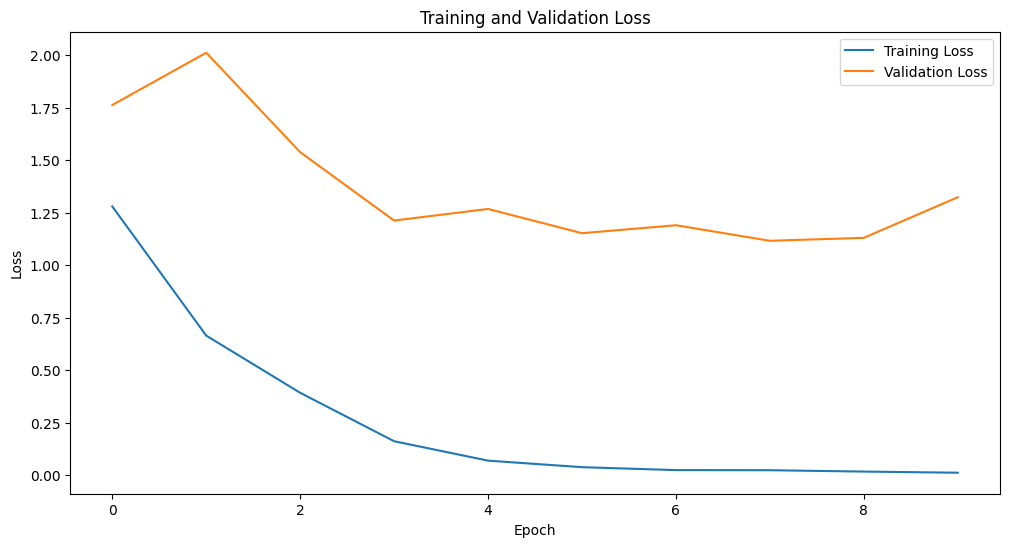

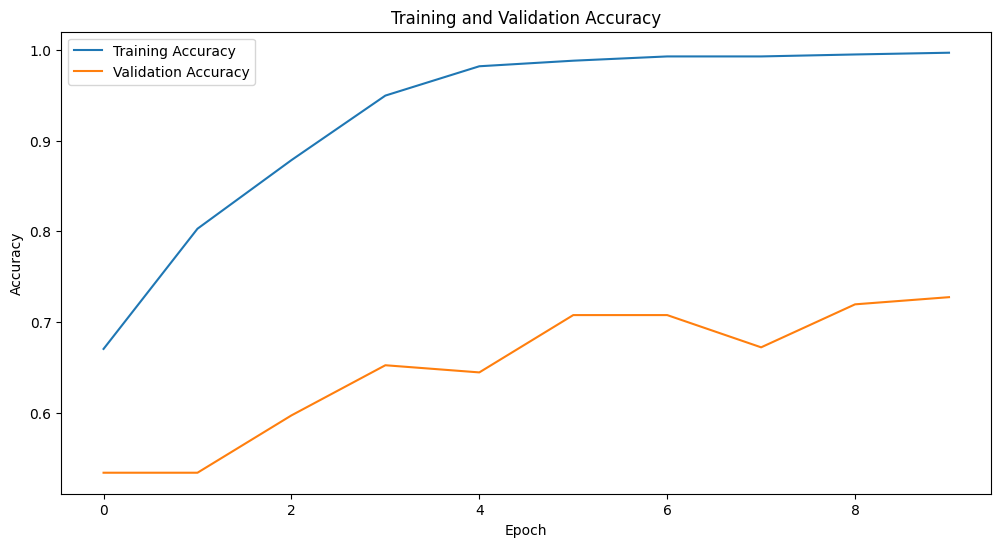

In [23]:
plot_loss_and_val_loss(feedback.train_loss_history, feedback.valid_loss_history)
plot_loss_and_val_accuracy(
    feedback.train_accuracy_history, feedback.valid_accuracy_history
)

In [24]:
model_2.eval()

test_loss, test_accuracy, _ = model_2.test(loss_fun_2, test_loader)

print("Accuracy of the network: %s %%" % (test_accuracy * 100))
print("Loss of the network: %s" % test_loss)

model_2.train()

Accuracy of the network: 69.9405637254902 %
Loss of the network: 1.2126588543256125


Lab2Student(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [25]:
result_model = CoTraining(
    device=device, modules=[model_1, model_2], num_classes=num_classes
)

loss_fun_res = CrossEntropyLoss()

In [26]:
result_model.eval()

test_loss, test_accuracy, _ = result_model.test(loss_fun_res, test_loader)

print("Accuracy of the network: %s %%" % (test_accuracy * 100))
print("Loss of the network: %s" % test_loss)

result_model.train()

Accuracy of the network: 77.1326593137255 %
Loss of the network: 1.405106540520986


CoTraining(
  (co_modules): ModuleList(
    (0-1): 2 x Lab2Student(
      (net): VGG(
        (features): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
          (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (9): ReLU(inplace=True)
          (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

10. Зберегти ваги навченої нейронної мережі у файл.

In [27]:
result_model.persist(MODELS_FOLDER / "lab-3-co-training.pickle")